In [1]:
import torch, pickle, time, os, random
import numpy as np
import os.path as osp
import matplotlib.pyplot as plt
import torch_geometric as tg
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split
# accelerate huggingface to GPU
if torch.cuda.is_available():
    from accelerate import Accelerator
    accelerator = Accelerator()
    device = accelerator.device

torch.manual_seed(42)
random.seed(42)

In [2]:
cols_t=['mstar stellar mass [1.0E09 Msun](0)',
 ' v_disk rotation velocity of disk [km/s] (1)',
 ' r_bulge 3D effective radius of bulge [kpc](2)',
 ' mcold cold gas mass in disk [1.0E09 Msun](3)',
 ' mHI cold gas mass [1.0E09 Msun](4)',
 ' mH2 cold gas mass [1.0E09 Msun](5)',
 ' mHII cold gas mass [1.0E09 Msun](6)',
 ' sfrave100myr SFR averaged over 100 Myr [Msun/yr](7)']

cols_t=['mstar stellar mass [1.0E09 Msun](0)',
 ' v_disk rotation velocity of disk [km/s] (1)',
 ' mcold cold gas mass in disk [1.0E09 Msun](3)',
 ' sfrave100myr SFR averaged over 100 Myr [Msun/yr](7)']

all_cols=np.array([0,2,4,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,35]+list(range(37,60)))
targets=[8,11,14,15,16,17,18,23]
targets=[8,11,15,23]

In [3]:
os.listdir(osp.expanduser('~/../../../scratch/gpfs/cj1223/GraphStorage/'))

['vlarge_all_4t_z1.0_standard_quant',
 'vlarge_all_4t_z1.0_quantile_raw',
 'vlarge_all_4t_z2.0_standard_quant',
 'vlarge_all_4t_z2.0_None',
 'redshift_scan_0',
 'vlarge_all_4t_z0.0_quantile_stand',
 'vlarge_all_multi_try1',
 'vlarge_all_4t_z2.0_quantile_raw',
 'vlarge_all_4t_z0.0_standard_quant',
 'vlarge_all_4t_z0.5_quantile_quant',
 'vlarge_all_4t_z2.0_quantile_stand',
 'vlarge_all_4t_z1.0_quantile_quant',
 'transformers',
 'vlarge_all_4t_z0.0_standard_raw',
 'vlarge_all_4t_z0.5_standard_stand',
 'vlarge_all_4t_z0.5_standard_quant',
 'vlarge_all_4t_z0.0_quantile_raw',
 'old',
 'vlarge_all_4t_z1.0_None',
 'vlarge_all_4t_z1.0_standard_stand',
 'vlarge_all_4t_z2.0_standard_raw',
 'vlarge_all_4t_z0.5_standard_raw',
 'vlarge_all_4t_z0.0_None',
 'vlarge_all_4t_z0.5_quantile_raw',
 'vlarge_all_4t_z1.0_standard_raw',
 'vlarge_all_smass',
 'vlarge_all_4t_z0.0_quantile_quant',
 'vlarge_all_4t_z0.5_quantile_stand',
 'vlarge_all_4t_z0.0_standard_stand',
 'vlarge_all_4t_z1.0_quantile_stand',
 'vl

In [4]:
case='vlarge_all_multi_try1/vlarge_all_multisimple_z0.0_quantile_raw'
case='vlarge_all_4t_z0.0_quantile_raw'



datat=pickle.load(open(osp.expanduser(f'~/../../../scratch/gpfs/cj1223/GraphStorage/{case}/data.pkl'), 'rb'))

In [5]:
from torch_geometric.data import Data

cols_t=['mstar stellar mass [1.0E09 Msun](0)',
 ' mcold cold gas mass in disk [1.0E09 Msun](3)']
targets=[8,15]
data=[]
for d in datat:
    data.append(Data(x=d.x, edge_index=d.edge_index, edge_attr=d.edge_attr, y=d.y[[0,1]]))

In [6]:
ys=[]
for d in data:
    ys.append(d.y.numpy())
ys=np.vstack(ys)

In [7]:
np.corrcoef(ys[:,0],ys[:,1])

array([[1.        , 0.89590685],
       [0.89590685, 1.        ]])

In [8]:
n_targ=len(data[0].y)
n_feat=len(data[0].x[0])
n_feat, n_targ

(43, 2)

In [9]:
import torch.nn.functional as F
from torch.nn import Linear, BatchNorm1d, LayerNorm, ModuleList
from torch_geometric.nn import SAGEConv, global_mean_pool, norm, global_max_pool, global_add_pool

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, n_lin=2, n_feat=1, n_targ=1):
        super(GCN, self).__init__()
        self.n_targ = n_targ
        self.n_feat = n_feat
        self.n_lin = n_lin
        self.conv1 = SAGEConv(n_feat, hidden_channels) ##use meta-layer
        ## https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.meta.MetaLayer
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, hidden_channels)
        self.conv4 = SAGEConv(hidden_channels, hidden_channels)
        self.conv5 = SAGEConv(hidden_channels, hidden_channels)
        
        
#         self.norm = LayerNorm(normalized_shape=hidden_channels) # layer_norm instead
        self.decoders = ModuleList()
        self.norms = ModuleList()
        for _ in range(n_targ):
            self.decoder=ModuleList()
            self.norm=ModuleList()
            for i in range(n_lin):
                if i==n_lin-1:
                    self.norm.append(LayerNorm(normalized_shape=hidden_channels))
                    self.decoder.append(Linear(hidden_channels, 1))
                else:
                    self.norm.append(LayerNorm(normalized_shape=hidden_channels))
                    self.decoder.append(Linear(hidden_channels, hidden_channels))
            self.decoders.append(self.decoder)
            self.norms.append(self.norm)

        self.sigs = ModuleList()
        self.sig_norms = ModuleList()
        for _ in range(n_targ):
            self.sig=ModuleList()
            self.sig_norm=ModuleList()
            for i in range(n_lin):
                if i==n_lin-1:
                    self.sig_norm.append(LayerNorm(normalized_shape=hidden_channels))
                    self.sig.append(Linear(hidden_channels, 1))
                else:
                    self.sig_norm.append(LayerNorm(normalized_shape=hidden_channels))
                    self.sig.append(Linear(hidden_channels, hidden_channels))
            self.sigs.append(self.sig)
            self.sig_norms.append(self.sig_norm)
        
    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = self.conv4(x, edge_index)
        x = x.relu()
        x = self.conv5(x, edge_index)
        x = x.relu()
        x = global_add_pool(x, batch)  ## Miles says use sumpool
        
        x_out=[]
        for norm, decode in zip(self.norms, self.decoders):# x = self.lin1(self.norm(x))
#             print(norm, decode)
            x1=torch.clone(x)
            for n, d in zip(norm, decode):
                x1=d(n(x1))
#                 print(x1.shape)
            x_out.append(x1)
        x_out=torch.cat(x_out, dim=1)
        
        sig=[]
        for norm, decode in zip(self.sig_norms, self.sigs):# x = self.lin1(self.norm(x))
            x1=torch.clone(x)
            for n, d in zip(norm, decode):
                x1=d(n(x1))
#                 print(x1.shape)
            sig.append(x1)
        sig=torch.abs(torch.cat(sig, dim=1))
    
        
        return x_out, sig
    
model = GCN(hidden_channels=64)
next(model.parameters()).is_cuda ##check number one

False

In [10]:
criterion = torch.nn.MSELoss()
n_epochs=100
n_trials=1
batch_size=128
split=0.8
test_data=data[int(len(data)*split):]
train_data=data[:int(len(data)*split)]
l1_lambda = 1e-5
l2_lambda = 1e-5

In [11]:
def l_func_2d(pred, ys, sig1, sig2):
    z1=(pred[:,0]-ys[:,0])/sig1
    z2=(pred[:,1]-ys[:,1])/sig2
    sigloss=torch.sum(torch.log(sig1)+torch.log(sig2))
    err_loss = torch.sum((z1**2+z2**2)/2)
    
    return err_loss+sigloss, err_loss, sigloss

In [12]:
# Initialize our train function

def train():
    model.train()
    for data in train_loader:  
        out, sigs = model(data.x, data.edge_index, data.batch)  
        loss, err_l, sig_l  = l_func_2d(out, data.y.view(-1,n_targ), sigs[:,0], sigs[:,1]) 
        l1_norm = sum(p.abs().sum() for p in model.parameters())
        l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())


        loss = loss + l1_lambda * l1_norm + l2_lambda * l2_norm
#             loss.backward()
        accelerator.backward(loss)
        optimizer.step() 
        optimizer.zero_grad() 
#     print(loss, l1_norm*l1_lambda, l2_norm*l2_lambda)
 # test function

def test(loader): ##### transform back missing
    model.eval()
    outs = []
    ys = []
    varss = []
    rhos = []
    with torch.no_grad(): ##this solves it!!!
        for dat in loader: 
            out, sigs = model(dat.x, dat.edge_index, dat.batch) 
            ys.append(dat.y.view(-1,n_targ))
            outs.append(out)
            varss.append(sigs)
    outss=torch.vstack(outs)
    yss=torch.vstack(ys)
    varss=torch.vstack(varss)
    return torch.std(outss - yss, axis=0), outss, yss, varss, rhos

In [13]:
trains, tests, scatter = [], [], []
yss, preds=[],[]
model = GCN(hidden_channels=64, n_feat=n_feat, n_targ=n_targ)
train_loader=DataLoader(train_data, batch_size=batch_size, shuffle=1, num_workers=4)
test_loader=DataLoader(test_data, batch_size=batch_size, shuffle=0,num_workers=4)    
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
_, _, test_loader = accelerator.prepare(model, optimizer, test_loader)
model, optimizer, train_loader = accelerator.prepare(model, optimizer, train_loader)
print('GPU ', next(model.parameters()).is_cuda)


GPU  True


In [14]:
#this uses about 1 GB of memory on the GPU
tr_acc, te_acc = [], []
start=time.time()
for epoch in range(n_epochs):

    train()

    if (epoch+1)%2==0:
        train_acc, _ , _, _ , _ = test(train_loader)
        test_acc, _ , _ , _ , _ = test(test_loader)
        tr_acc.append(train_acc.cpu().numpy())
        te_acc.append(test_acc.cpu().numpy())
        print(f'Epoch: {epoch+1:03d}, Train scatter: {np.round(train_acc.cpu().numpy(), 4)} \n \
          Test scatter:  {np.round(test_acc.cpu().numpy(), 4)}')
stop=time.time()
spent=stop-start
print(f"{spent:.2f} seconds spent training, {spent/n_epochs:.3f} seconds per epoch. Processed {len(data)*split*n_epochs/spent:.0f} trees per second")


Epoch: 002, Train scatter: [0.7613 0.1041] 
           Test scatter:  [0.755 0.103]
Epoch: 004, Train scatter: [0.3384 0.0916] 
           Test scatter:  [0.3387 0.0895]
Epoch: 006, Train scatter: [0.288  0.0794] 
           Test scatter:  [0.2873 0.0774]
Epoch: 008, Train scatter: [0.2382 0.0738] 
           Test scatter:  [0.2315 0.0718]
Epoch: 010, Train scatter: [0.1909 0.0669] 
           Test scatter:  [0.1876 0.066 ]
Epoch: 012, Train scatter: [0.1799 0.061 ] 
           Test scatter:  [0.1721 0.0603]
Epoch: 014, Train scatter: [0.1587 0.0539] 
           Test scatter:  [0.1505 0.0534]
Epoch: 016, Train scatter: [0.2154 0.064 ] 
           Test scatter:  [0.2101 0.0637]
Epoch: 018, Train scatter: [0.8262 0.1638] 
           Test scatter:  [0.8226 0.162 ]
Epoch: 020, Train scatter: [0.8056 0.1212] 
           Test scatter:  [0.8039 0.1208]
Epoch: 022, Train scatter: [0.4654 0.1119] 
           Test scatter:  [0.4741 0.1128]
Epoch: 024, Train scatter: [0.3539 0.1032] 
           T

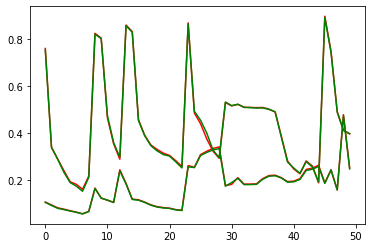

In [15]:
plt.plot(tr_acc, 'r-')
plt.plot(te_acc, 'g-')

Text(0.5, 0.98, '2D Gaussian Loss without correlation')

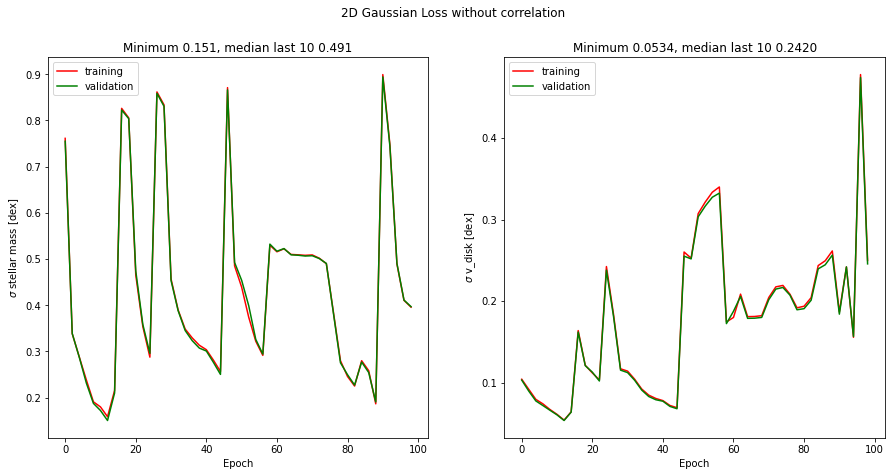

In [23]:
te_acc, tr_acc = np.array(te_acc), np.array(tr_acc)
fig, ax =plt.subplots(1,2,figsize=(15,7))
ax[0].plot(np.arange(0,100,2), tr_acc[:,0], 'r-', label='training')
ax[0].plot(np.arange(0,100,2), te_acc[:,0], 'g-',label='validation')
ax[0].set(xlabel='Epoch', ylabel=r'$\sigma$ stellar mass [dex]', \
    title=f'Minimum {np.min(np.array(te_acc)[:,0]):.3f}, median last 10 {np.median(np.array(te_acc)[-5:,0]):.3f}')
ax[0].legend()

ax[1].plot(np.arange(0,100,2), tr_acc[:,1], 'r-', label='training')
ax[1].plot(np.arange(0,100,2), te_acc[:,1], 'g-',label='validation')
ax[1].set(xlabel='Epoch', ylabel=r'$\sigma$ v_disk [dex]', \
    title=f'Minimum {np.min(np.array(te_acc)[:,1]):.4f}, median last 10 {np.median(np.array(te_acc)[-5:,1]):.4f}')
ax[1].legend()

fig.suptitle('2D Gaussian Loss without correlation')

In [16]:
trainstd, outtrain, ytrain, var, rho = test(train_loader)

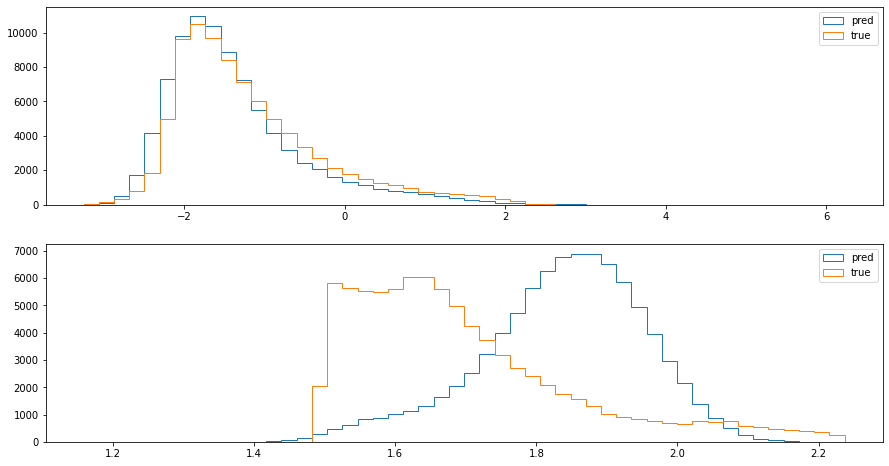

In [17]:
fig , ax = plt.subplots(2, figsize=(15,8))
ax = ax.flatten()
l=0
for k in range(n_targ):
#     ax[k].hist(ress.cpu().numpy()[:,k], bins=50, histtype='step', label='res')
    ax[k].hist(outtrain.cpu().numpy()[:,k], bins=50, \
            range=list(np.percentile(outtrain.cpu().numpy()[:,k], [l,100-l])), histtype='step', label='pred')
    ax[k].hist(ytrain.cpu().numpy()[:,k], bins=50, \
            range=list(np.percentile(outtrain.cpu().numpy()[:,k], [l,100-l])), histtype='step', label='true')

    ax[k].legend()
#     print(np.std(ress.cpu().numpy()[:,k]), np.mean(ress.cpu().numpy()[:,k]))

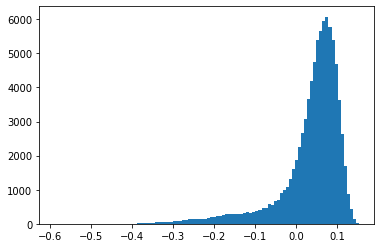

In [18]:
i=1
plt.hist((outtrain.cpu().numpy()[:,i]-ytrain.cpu().numpy()[:,i])/var[:,i].cpu().numpy(), bins=100);

(array([4.3517e+04, 4.0374e+04, 3.1220e+03, 2.9000e+01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 3.0000e+00]),
 array([0.2513385 , 0.34545594, 0.43957338, 0.5336908 , 0.6278083 ,
        0.7219257 , 0.81604314, 0.91016054, 1.004278  , 1.0983955 ,
        1.1925129 ], dtype=float32),
 <BarContainer object of 10 artists>)

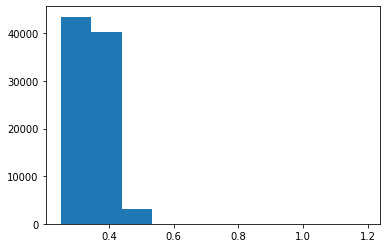

In [19]:
plt.hist(var.cpu().numpy()[:,0])

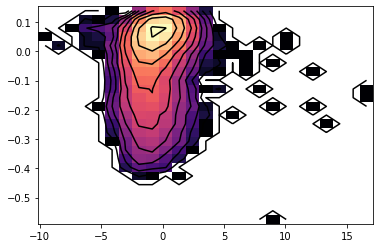

In [20]:
import matplotlib as mpl
i=0
z0=(outtrain.cpu().numpy()[:,i]-ytrain.cpu().numpy()[:,i])/var[:,i].cpu().numpy()
i=1
z1=(outtrain.cpu().numpy()[:,i]-ytrain.cpu().numpy()[:,i])/var[:,i].cpu().numpy()
vals, x, y, ax=plt.hist2d(z0,z1,bins=25, norm=mpl.colors.LogNorm(), cmap=mpl.cm.magma)
X, Y = np.meshgrid((x[1:]+x[:-1])/2, (y[1:]+y[:-1])/2)
plt.contour(X,Y, np.log(vals.T+1), levels=10, colors='black')

In [21]:
np.corrcoef(z0,z1)

array([[1.        , 0.25175934],
       [0.25175934, 1.        ]])

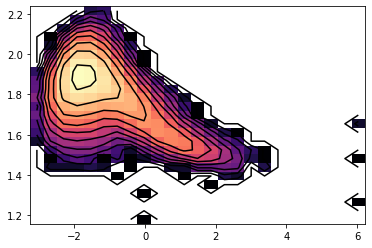

In [22]:
import matplotlib as mpl
vals, x, y, ax=plt.hist2d(outtrain.cpu().numpy()[:,0],outtrain.cpu().numpy()[:,1],bins=25, norm=mpl.colors.LogNorm(), cmap=mpl.cm.magma)
X, Y = np.meshgrid((x[1:]+x[:-1])/2, (y[1:]+y[:-1])/2)
plt.contour(X,Y, np.log(vals.T+1), levels=10, colors='black')

In [39]:
np.corrcoef(outtrain.cpu().numpy()[:,0],outtrain.cpu().numpy()[:,1])

array([[1.        , 0.98528572],
       [0.98528572, 1.        ]])

In [40]:
(x[1:]+x[:-1])/2

array([-2.91437507, -2.69487548, -2.47537589, -2.2558763 , -2.03637671,
       -1.81687713, -1.59737754, -1.37787795, -1.15837836, -0.93887877,
       -0.71937919, -0.4998796 , -0.28038001, -0.06088042,  0.15861917,
        0.37811875,  0.59761834,  0.81711793,  1.03661752,  1.25611711,
        1.47561669,  1.69511628,  1.91461587,  2.13411546,  2.35361505])

In [2]:
fig , ax = plt.subplots(2, figsize=(15,25))
ax = ax.flatten()
l=0.5
for k in range(n_targ):
    ytr=ytrain.cpu().numpy()[:,k]
    predtr=outtrain.cpu().numpy()[:,k]
    ax[k].plot(ytr, predtr, 'ro', label='true-pred')
    ax[k].plot([min(ytr),max(ytr)],[min(ytr),max(ytr)], 'k--', label='Perfect correspondance')
    ax[k].set(title=[cols_t[k], np.round(np.std(ytr-predtr),2), np.round(np.mean(ytr-predtr),2)])
    ax[k].legend()
#     print(np.std(ress.cpu().numpy()[:,k]), np.mean(ress.cpu().numpy()[:,k]))

NameError: name 'plt' is not defined

In [ ]:
teststd, outtest, ytest, vtest, rhotest = test(train_loader)

In [ ]:
fig , ax = plt.subplots(2,2, figsize=(15,10))
ax = ax.flatten()
l=0.01
for k in range(n_targ):
    ax[k].hist(outtest.cpu().numpy()[:,k], bins=50, \
            range=list(np.percentile(outtest.cpu().numpy()[:,k], [l,100-l])), histtype='step', label='pred')
    ax[k].hist(ytest.cpu().numpy()[:,k], bins=50, \
            range=list(np.percentile(outtest.cpu().numpy()[:,k], [l,100-l])), histtype='step', label='true')
    ax[k].set(title=cols_t[k])
    ax[k].legend()
#     print(np.std(ress.cpu().numpy()[:,k]), np.mean(ress.cpu().numpy()[:,k]))
fig.tight_layout()

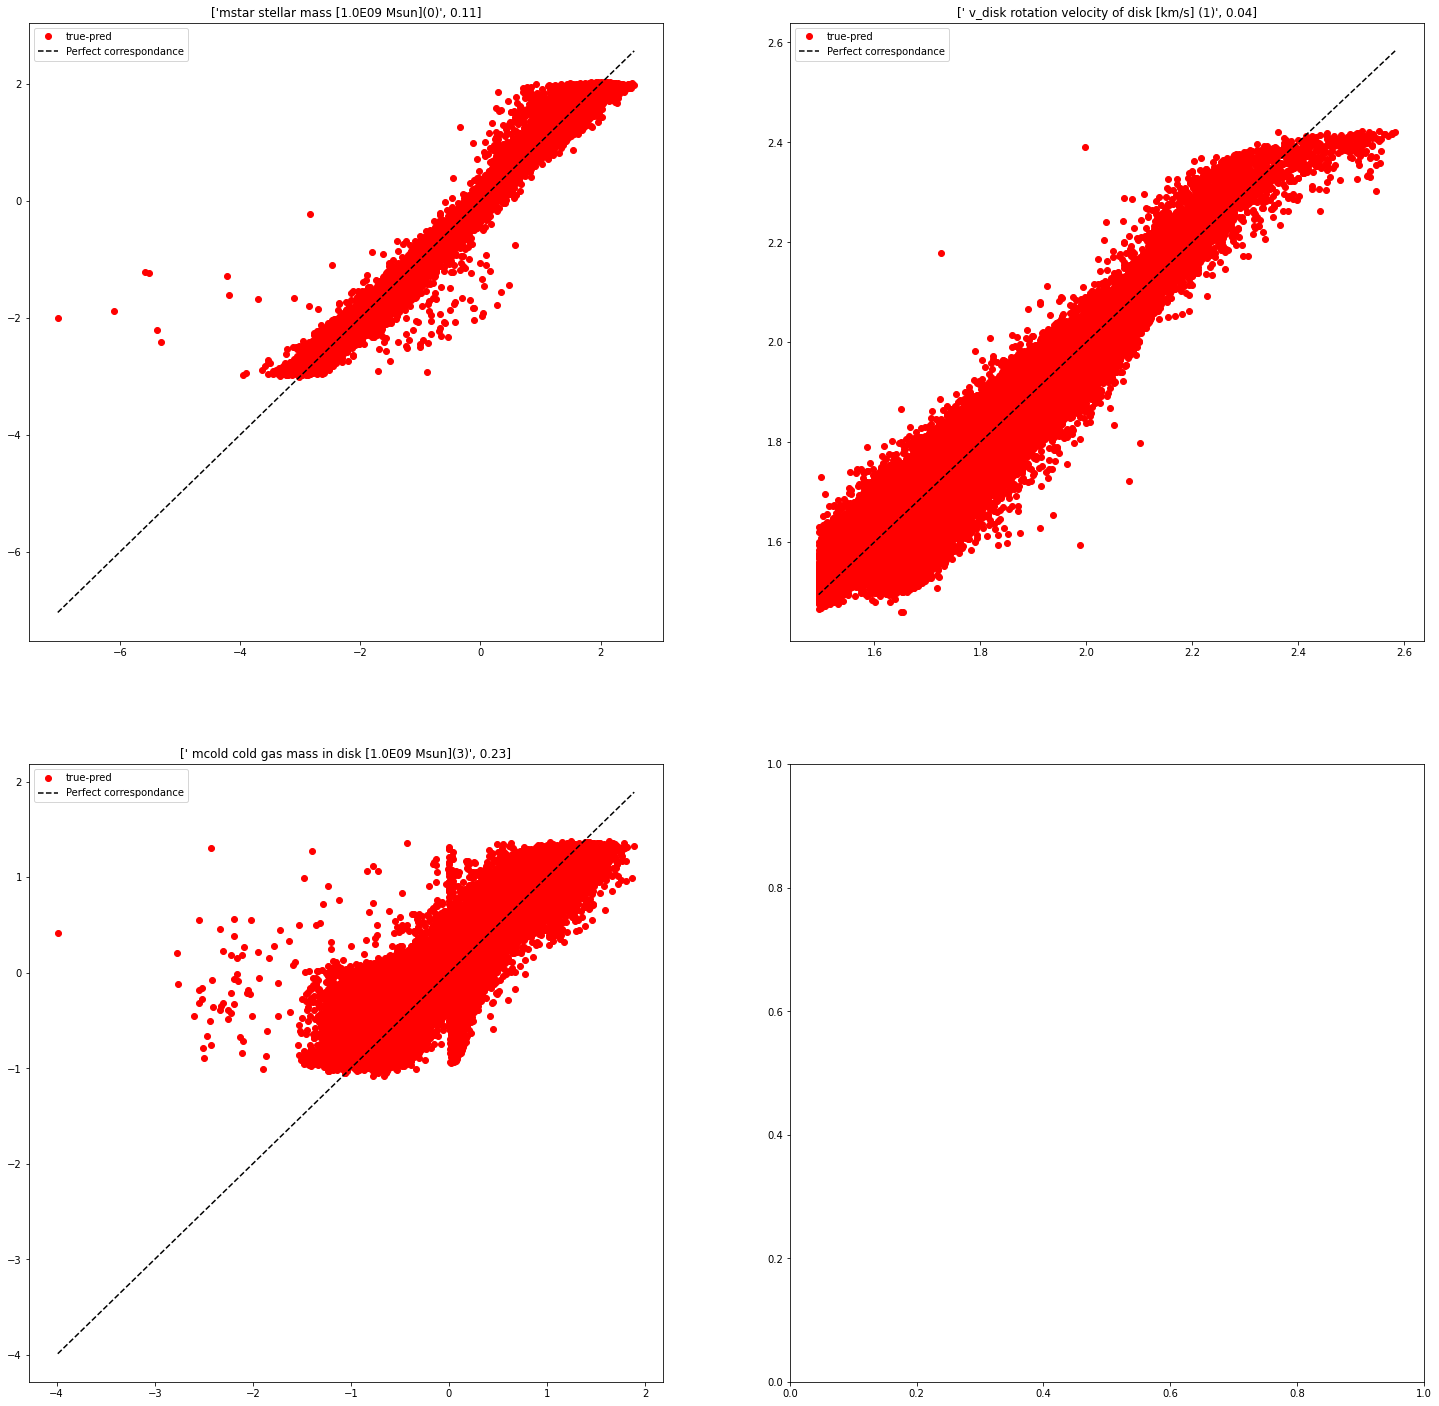

In [19]:
fig , ax = plt.subplots(2,2, figsize=(25,25))
ax = ax.flatten()
for k in range(n_targ):
    yte=ytest.cpu().numpy()[:,k]
    predte=outtest.cpu().numpy()[:,k]
    ax[k].plot(yte, predte, 'ro', label='true-pred')
    ax[k].plot([min(yte),max(yte)],[min(yte),max(yte)], 'k--', label='Perfect correspondance')
    ax[k].set(title=[cols_t[k], np.round(np.std(yte-predte),2)])
    ax[k].legend()
#     print(np.std(ress.cpu().numpy()[:,k]), np.mean(ress.cpu().numpy()[:,k]))

In [20]:
transform='quantile'
transform_path=osp.expanduser(f"~/../../../scratch/gpfs/cj1223/GraphStorage/transformers/{transform}_alltarg_1.pkl")
target_scaler=pickle.load(open(transform_path, 'rb'))

transform_path=osp.expanduser(f"~/../../../scratch/gpfs/cj1223/GraphStorage/transformers/{transform}_allfeat_1.pkl")
feat_scaler=pickle.load(open(transform_path, 'rb'))

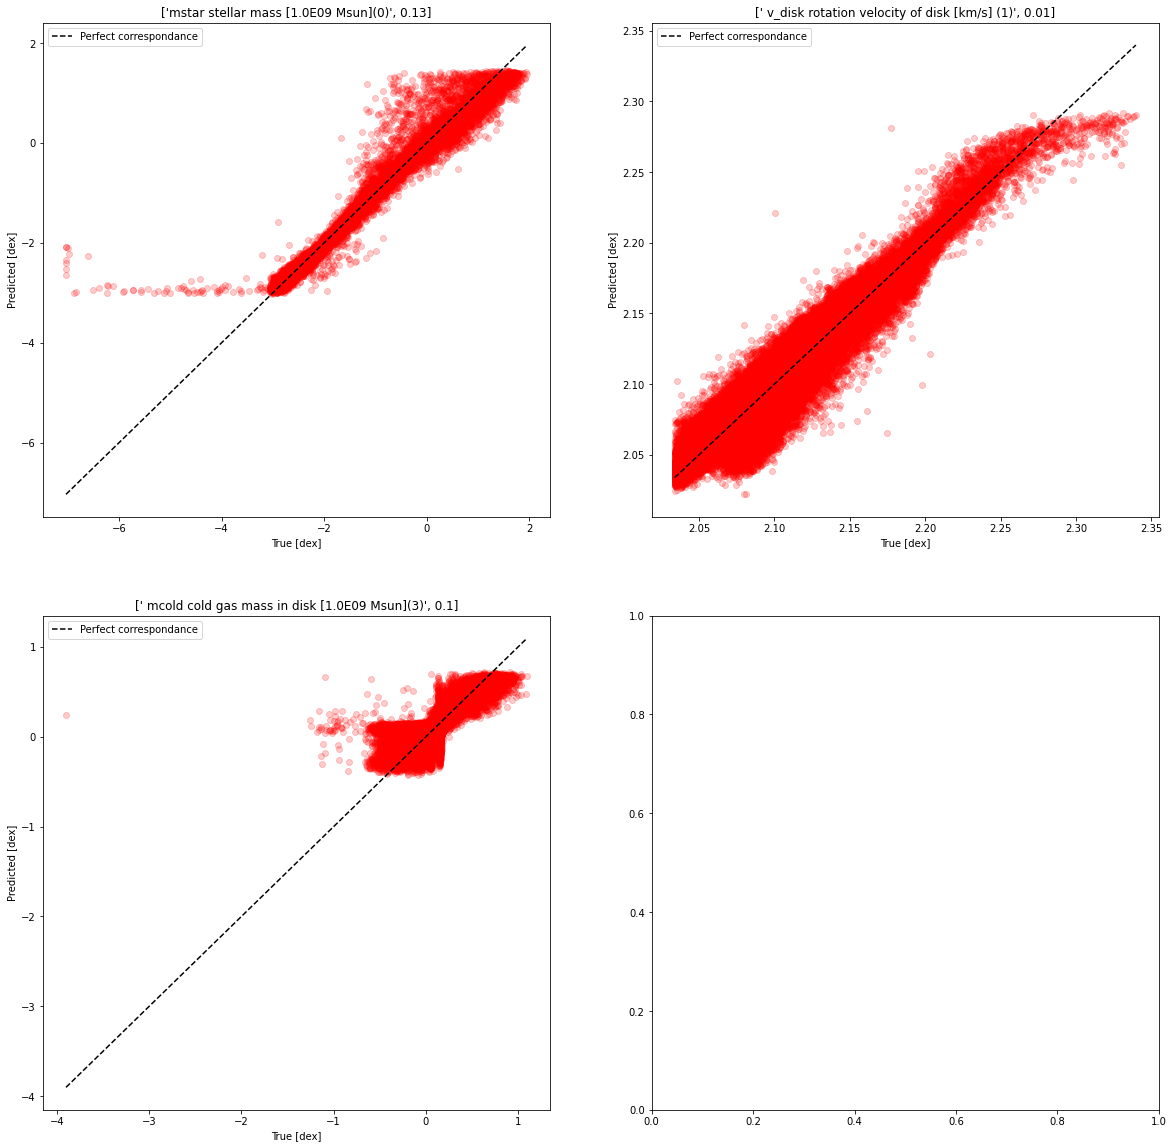

In [21]:
fig , ax = plt.subplots(2,2, figsize=(20,20))
ax = ax.flatten()
for k in range(n_targ):
    yte=np.hstack(target_scaler[targets[k]].inverse_transform(ytest.cpu().numpy()[:,k].reshape(-1,1)))
    predte=np.hstack(target_scaler[targets[k]].inverse_transform(outtest.cpu().numpy()[:,k].reshape(-1,1)))
    ax[k].plot(yte, predte, 'ro', alpha=0.2)
    ax[k].plot([min(yte),max(yte)],[min(yte),max(yte)], 'k--', label='Perfect correspondance')
    ax[k].set(title=[cols_t[k], np.round(np.std(yte-predte),2)], xlabel='True [dex]', ylabel='Predicted [dex]')
    ax[k].legend()